In [1]:
'''顔認識の決定木作成'''
print(__doc__)

顔認識の決定木作成


決定木の理解のために、顔の構成部品のあるなしだけのデータだけで顔に見えるかどうかを判定する決定木を作成してみる。

- 参考サイト [ブースティングで、簡単な真顔と偽顔の図形を識別する](http://ishidate.my.coocan.jp/opencv_16/opencv_16.htm)

参考にしたサイトはBoostingによる顔認識を理解するために問題を単純化して扱っているのだが、その表現を使わせてもらい、Boostingではなく決定木を作成してみる。

<img width="638" alt="2017-09-20 13 59 38" src="https://user-images.githubusercontent.com/5820803/30627844-b9c8a00c-9e0d-11e7-95cc-4b71d4f72995.png">

### 必要な非標準モジュール
- graphviz
- pydotplus
- opencv2

#### graphviz

> pip install graphviz

でインストール可能

##### Windows の場合、
- [Graphviz - Graph Visualization Software](http://www.graphviz.org/Download_windows.php) で入手できます。

#### pydotplus

> pip install pydotplus

#### graphviz



In [2]:
# !pip install graphviz  
# !pip install pydotplus 

In [3]:
# モジュールのインポート
import pandas as pd
from sklearn import tree
from sklearn.externals.six import StringIO
from graphviz import Digraph
import pydotplus
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import cv2
from  PIL import Image,ImageDraw,ImageFont
import numpy as np
from IPython.display import display

FONTPATH = "C:\\Windows\\Fonts\\meiryo.ttc"

# 描画メソッド
描画する必要はないが、不要だが、０１データでは素っ気ないので描画してみる。  
視覚化すると判断がそれに引きずられる可能性があるので良し悪しであるが。

In [4]:
WIDTH, HEIGHT = 70,90
         
# 上のデータを簡易画像として表示するメソッド
def drawFaces(faces, i, b = None):
    faceparts = faces[i]
    img = Image.new('RGB', (WIDTH, HEIGHT), (255, 255, 255))    
    dr = ImageDraw.Draw(img)
    if faceparts[0]==1:   # 左まゆ 棒状
        dr.rectangle(((15,22),(25,28)),(0,0,0),1)
    if faceparts[1]==1:   # 右まゆ
        dr.rectangle(((45,22),(55,28)),(0,0,0),1)
    if faceparts[2]==1:  # 左目 まんまる
        dr.ellipse(((16,31),(24,39)), (0,0,0),1)
    if faceparts[3]==1:  # 右目　　まんまる
        dr.ellipse(((46,31),(54,39)), (0,0,0),1) 
    if faceparts[4]==1:  # 鼻　　団子っ鼻
        dr.ellipse(((26,43),(34,47)), (0,0,0),1)
    if faceparts[5]==1:  # 口　横開き
        dr.ellipse(((22,63),(38,67)), (0,0,0),1) 
    if faceparts[6]==1:  # 左頬
        dr.ellipse(((5,42),(15,58)), (0,0,0),1) 
    if faceparts[7]==1:  # 右頬
        dr.ellipse(((55,42),(65,58)), (0,0,0),1) 
    if faceparts[8]==1:  # でこぼくろ
        dr.ellipse(((30,12),(40,18)), (0,0,0),1) 
    # 輪郭
    dr.ellipse(((5,5),(65,85)), None,(0,0,0))
    font = ImageFont.truetype(FONTPATH, 10)
    # font = ImageFont.truetype('Meiryo', 10)
    dr.text((0,75),("True" if b==1 else ("False" if b==0 else "?")),(255,0,0),font =font)
    return img    

#def expandfeatureVec(vec) :# ３値の成分を２値✕２に置き換える 返り値はただのリスト
#      return np.array(vec).astype(np.float32)

# def expandfeatureVecAll(faces): # 返り値は array
    list = []
    for vec in faces:
        list.append(expandfeatureVec(vec))
    return np.array(list).astype(np.float32)

def drawsamples(faces, text, nums ):
    t_canvas = Image.new('RGB', (WIDTH*10, HEIGHT+35), (255, 255, 255))   # 訓練例の表示のためのキャンバス（表示のみ）
    for i in range(10): # 学習用の正の例と負の例それぞれ10個ずつを読み込み
        dr = ImageDraw.Draw(t_canvas)
        font = ImageFont.truetype(FONTPATH, 24)
        dr.text((0,0),text,(0,0,0),font =font)
        t_canvas.paste(drawFaces(faces,nums[i],nums[i]<15),(WIDTH*i, 35))
    display(t_canvas)
    return t_canvas

# 識別対象データ
顔の構成部品のある無しのみのリストを対象データとする

In [5]:
faces=np.array([
    # 9 つの成分の意味
    # 第0成分: 左眉 0:なし、1:あり
    # 第1成分: 右眉 0:なし、1:あり
    # 第2成分: 左目 0:なし、1:あり
    # 第3成分: 右目 0:なし、1:あり
    # 第4成分: 　鼻 0:なし、1:あり
    # 第5成分: 　口 0:なし、1:あり
    # 第6―8成分: ほくろ　第6　左頬 第7　右頬　第８　おでこ

    [1,1,1,1,1,1,0,0,0], #0
    [0,1,1,1,1,1,0,0,0], #1
    [1,0,1,1,1,0,0,0,0], #2
    [1,1,1,1,0,1,0,0,0], #3
    [1,1,1,0,1,1,0,0,0], #4
    [1,1,0,1,1,1,0,0,0], #5
    [0,0,1,1,0,1,0,0,0], #6
    [1,1,1,1,1,0,1,0,0], #7
    [0,0,1,1,1,1,0,1,0], #8
    [1,1,1,1,1,1,0,0,1], #9

    [1,1,1,1,1,1,1,1,0], #10
    [0,1,1,1,1,1,1,0,1], #11
    [0,0,1,1,1,0,0,0,0], #12
    [1,0,1,1,1,1,0,1,1], #13
    [1,1,1,1,0,0,0,0,1], #14
    # 正の例ここまで

    [0,0,0,0,1,1,0,0,0], #15
    [1,0,0,0,1,1,1,1,1], #16
    [0,1,0,1,0,1,0,0,0], #17
    [1,0,1,0,0,1,0,0,0], #18
    [0,1,0,1,0,1,1,0,0], #19
    [1,0,1,0,1,0,1,0,0], #20
    [1,0,1,0,0,1,1,0,0], #21
    [0,1,0,1,0,1,0,0,1], #22
    [1,1,0,0,1,0,1,1,0], #23
    [0,0,0,0,0,1,1,1,1], #24

    [0,0,0,0,1,1,0,0,1], #25
    [1,0,1,0,0,0,1,0,0], #26
    [1,1,0,0,1,1,1,1,0], #27
    [1,1,0,0,1,1,0,0,0], #28
    [1,0,1,0,1,1,0,1,0] #29
    # 負の例ここまで
    ])

items1=['右眉','左眉','右目','左目','鼻','口','右黒子','左黒子','額黒子']
items2=['正負','判定結果']
pm=np.r_[['+']*15,['-']*15]
dr=np.array([None]*30)
fd = pd.DataFrame(np.c_[faces,pm,dr],columns=np.r_[items1,items2])

#list('+++++++++++++++---------------')
fd

,右眉,左眉,右目,左目,鼻,口,右黒子,左黒子,額黒子,正負,判定結果
0,1,1,1,1,1,1,0,0,0,+,None
1,0,1,1,1,1,1,0,0,0,+,None
2,1,0,1,1,1,0,0,0,0,+,None
3,1,1,1,1,0,1,0,0,0,+,None
4,1,1,1,0,1,1,0,0,0,+,None
5,1,1,0,1,1,1,0,0,0,+,None
6,0,0,1,1,0,1,0,0,0,+,None
7,1,1,1,1,1,0,1,0,0,+,None
8,0,0,1,1,1,1,0,1,0,+,None
9,1,1,1,1,1,1,0,0,1,+,None


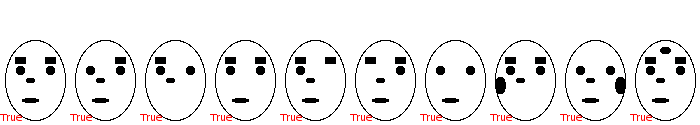

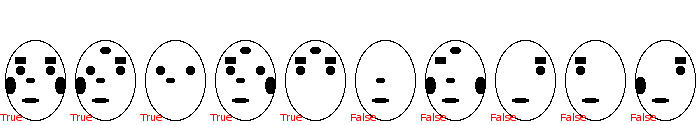

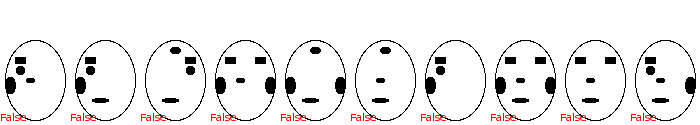

In [6]:
drawsamples(faces,"",np.arange(10))  # 
drawsamples(faces,"",np.arange(10,20)) # 
drawsamples(faces,"",np.arange(20,30)); #

# 事例を訓練用とテスト用に分割
正の例，負の例いずれも15例中10例を訓練用，残りをテスト用とする

（下のブロックは実行するたびにランダムに変化します）

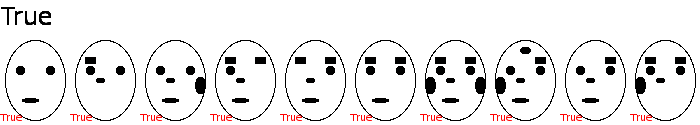

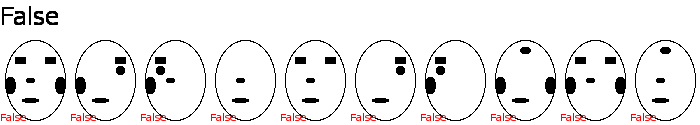

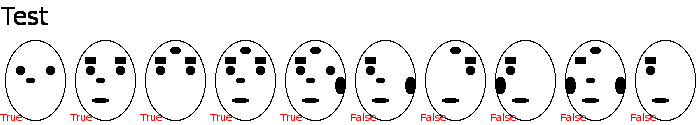

In [7]:
rdT = np.random.permutation(np.arange(15))    # 正の例を並べ替え
rdF = np.random.permutation(np.arange(15,30)) # 負の例を並べ替え
train = np.r_[rdT[:10],rdF[:10]] # 正負先頭から１０個ずつ連結
test = np.r_[rdT[10:],rdF[10:]]  # 残りをテストデータとする
drawsamples(faces,"True",train[:10])  # 
drawsamples(faces,"False",train[10:]) # 
drawsamples(faces,"Test",test); # 

# 決定木の生成プログラム

In [8]:
fd['判定結果']=np.nan * 30
truefaces = faces[rdT[:10]] # 顔特長ベクトルの正の例10個
falsefaces = faces[rdF[:10]] # 顔特長ベクトルの負の例10個
testfaces = faces[test]

# rdT[:10],rdF[:10],test
pdata = fd.iloc[np.r_[rdT[:10],rdF[:10]]]
tdata = fd.iloc[test]
#pdata = pd.DataFrame(np.r_[truefaces,falsefaces],columns=['右眉','左眉','右目','左目','鼻','口','右黒子','左黒子','額黒子'])
#tdata = pd.DataFrame(testfaces,columns=['右眉','左眉','右目','左目','鼻','口','右黒子','左黒子','額黒子'])

In [9]:
#データの確認
pdata

,右眉,左眉,右目,左目,鼻,口,右黒子,左黒子,額黒子,正負,判定結果
6,0,0,1,1,0,1,0,0,0,+,NaN
2,1,0,1,1,1,0,0,0,0,+,NaN
8,0,0,1,1,1,1,0,1,0,+,NaN
4,1,1,1,0,1,1,0,0,0,+,NaN
5,1,1,0,1,1,1,0,0,0,+,NaN
3,1,1,1,1,0,1,0,0,0,+,NaN
10,1,1,1,1,1,1,1,1,0,+,NaN
11,0,1,1,1,1,1,1,0,1,+,NaN
1,0,1,1,1,1,1,0,0,0,+,NaN
7,1,1,1,1,1,0,1,0,0,+,NaN


In [10]:
tdata

,右眉,左眉,右目,左目,鼻,口,右黒子,左黒子,額黒子,正負,判定結果
12,0,0,1,1,1,0,0,0,0,+,NaN
0,1,1,1,1,1,1,0,0,0,+,NaN
14,1,1,1,1,0,0,0,0,1,+,NaN
9,1,1,1,1,1,1,0,0,1,+,NaN
13,1,0,1,1,1,1,0,1,1,+,NaN
29,1,0,1,0,1,1,0,1,0,-,NaN
22,0,1,0,1,0,1,0,0,1,-,NaN
21,1,0,1,0,0,1,1,0,0,-,NaN
16,1,0,0,0,1,1,1,1,1,-,NaN
18,1,0,1,0,0,1,0,0,0,-,NaN


# 決定木の準備

In [11]:
classifier = tree.DecisionTreeClassifier()

# 訓練データもとに決定木を構成する


In [12]:
classifier.fit(pdata[items1],pd.DataFrame(list('++++++++++----------')));

# 完成した決定木をPDFで出力

In [13]:
dot_data = StringIO() # 仮想テキストファイル
tree.export_graphviz(classifier, out_file=dot_data) # 決定木の描画用データ dot_data を生成する
tree.export_graphviz(classifier, out_file="dot_data.dot") # 決定木の描画用データ dot_data を生成する
dot_text = dot_data.getvalue() # dot_data を文字列として取り出し， X[_] を表見出しに使っている言葉で置換

In [14]:
dot_text = dot_text.replace('X[0] <= 0.5',u'右眉がない').replace('X[1] <= 0.5',u'左眉がない').replace('X[2] <= 0.5',u'右目がない').replace('X[3] <= 0.5','左目がない')
dot_text = dot_text.replace('X[4] <= 0.5','鼻がない').replace('X[5] <= 0.5','口がない').replace('X[6] <= 0.5','右黒子がない').replace('X[7] <= 0.5','左黒子がない').replace('X[8] <= 0.5','額黒子がない')

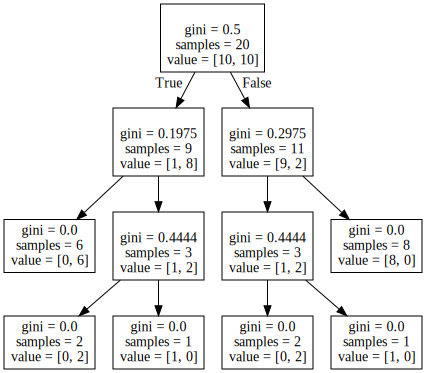

In [15]:
from graphviz import Source
src = Source(dot_text)
src

In [16]:
# 決定木を PDF, png ファイルとして出力
graph = pydotplus.graph_from_dot_data(dot_text)
for node in graph.get_nodes():
    node.set_fontname("Meiryo")
    
# graph.fontname="Meiryo"
import PIL
graph.write_pdf('facedetectTree.pdf')
graph.write_png('facedetectTree.png')  #png 画像として書き出し
# PIL.Image.open('facedetectTree.png')

True

# 全判定結果

In [17]:
fd['判定結果']=classifier.predict(fd[items1])
fd

,右眉,左眉,右目,左目,鼻,口,右黒子,左黒子,額黒子,正負,判定結果
0,1,1,1,1,1,1,0,0,0,+,+
1,0,1,1,1,1,1,0,0,0,+,+
2,1,0,1,1,1,0,0,0,0,+,+
3,1,1,1,1,0,1,0,0,0,+,+
4,1,1,1,0,1,1,0,0,0,+,+
5,1,1,0,1,1,1,0,0,0,+,+
6,0,0,1,1,0,1,0,0,0,+,+
7,1,1,1,1,1,0,1,0,0,+,+
8,0,0,1,1,1,1,0,1,0,+,+
9,1,1,1,1,1,1,0,0,1,+,+


#  訓練事例の設定された真偽と判定結果の真偽の比較

In [18]:
pdata = fd.iloc[np.r_[rdT[:10],rdF[:10]]]
pdata

,右眉,左眉,右目,左目,鼻,口,右黒子,左黒子,額黒子,正負,判定結果
6,0,0,1,1,0,1,0,0,0,+,+
2,1,0,1,1,1,0,0,0,0,+,+
8,0,0,1,1,1,1,0,1,0,+,+
4,1,1,1,0,1,1,0,0,0,+,+
5,1,1,0,1,1,1,0,0,0,+,+
3,1,1,1,1,0,1,0,0,0,+,+
10,1,1,1,1,1,1,1,1,0,+,+
11,0,1,1,1,1,1,1,0,1,+,+
1,0,1,1,1,1,1,0,0,0,+,+
7,1,1,1,1,1,0,1,0,0,+,+


#  テスト事例の設定された真偽と判定結果の真偽の比較

In [19]:
tdata = fd.iloc[test]
tdata

,右眉,左眉,右目,左目,鼻,口,右黒子,左黒子,額黒子,正負,判定結果
12,0,0,1,1,1,0,0,0,0,+,+
0,1,1,1,1,1,1,0,0,0,+,+
14,1,1,1,1,0,0,0,0,1,+,+
9,1,1,1,1,1,1,0,0,1,+,+
13,1,0,1,1,1,1,0,1,1,+,+
29,1,0,1,0,1,1,0,1,0,-,-
22,0,1,0,1,0,1,0,0,1,-,-
21,1,0,1,0,0,1,1,0,0,-,-
16,1,0,0,0,1,1,1,1,1,-,-
18,1,0,1,0,0,1,0,0,0,-,-
